# Equity Model

The goal of this notebook is to develop an equity model for fast inference.

In [1]:
import itertools
import joblib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn import pipeline

import poker_coach

# Generate Data

Data will be generated using the *Monte Carlo* procedure.

In [2]:
hero_range = range(0, 101, 1)
villain_range = range(0, 101, 1)
n_times = 10000

## Training Data

In [3]:
%%time

# train = pd.read_csv(r"poker_coach\data\linear_model_train.csv", index_col=0)
# train.head()

prod = itertools.product(hero_range, villain_range)

train = pd.DataFrame()

for h, v in prod:
    
    # Get hand from ranking.
    hero_hand = poker_coach.equity.percentage_descr(h)

    # Calculate equity agains villain range.
    equity = poker_coach.Scenario.eval_ranges(hero_hand, [v], times=n_times)
    
    train = train.append({"Hero": h, "Villain": v, "Equity": equity[0]}, ignore_index=True)
    
train.to_csv(r"poker_coach\data\linear_model_train.csv")
train.head()

Wall time: 11 ms


,Equity,Hero,Villain
0,0.500100,0.0,0.0
1,0.607975,0.0,1.0
2,0.699372,0.0,2.0
3,0.754498,0.0,3.0
4,0.781247,0.0,4.0


In [4]:
%%time

# test = pd.read_csv(r"poker_coach\data\linear_model_test.csv", index_col=0)
# test.head()

test_size = 0.25

test = pd.DataFrame()
for _ in range(int(train.shape[0] * test_size)):
    
    # Choose randomly hero and villain ranges.
    h = np.random.randint(min(hero_range), max(hero_range))
    hero_hand = poker_coach.equity.percentage_descr(h)
    v = np.random.randint(min(villain_range), max(villain_range))
    
    # Calculate equity agains villain range.
    equity = poker_coach.Scenario.eval_ranges(hero_hand, [v], times=n_times)
    
    test = test.append({"Hero": h, "Villain": v, "Equity": equity[0]}, ignore_index=True)
    
test.to_csv(r"poker_coach\data\linear_model_test.csv")
test.head()

Wall time: 9.5 ms


,Equity,Hero,Villain
0,0.572314,29.0,63.0
1,0.625985,31.0,84.0
2,0.474614,59.0,53.0
3,0.468662,80.0,57.0
4,0.462949,53.0,41.0


## Testing Data

In [5]:
x_train = train[["Hero", "Villain"]]
y_train = train[["Equity"]]

x_test = test[["Hero", "Villain"]]
y_test = test[["Equity"]]

# Fit Model

In [6]:
pipe = pipeline.Pipeline(
    [
        ("random forest", ensemble.RandomForestRegressor(
            n_estimators=100, 
            max_depth=8,
        )),
    ]
)

pipe.fit(x_train, y_train.values.ravel())
pipe.score(x_test, y_test)

0.9906839833556287

# Visualize Model Predictions

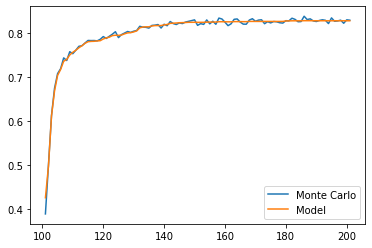

In [7]:
train["Predicted Equity"] = pipe.predict(x_train)

temp = train[train["Hero"] == np.random.choice(train["Hero"])]

plt.plot(temp["Equity"], label="Monte Carlo")
plt.plot(temp["Predicted Equity"], label="Model")
plt.legend()

# Save Model

In [8]:
joblib.dump(pipe, 'model.pkl') 

['model.pkl']